# Microchip Quality Assurance : Regularized Logistic Regression

## Introduction

The project will implement the Regularized Logistic Regression + scipy to predict whether a microchip should pass QA. The objective is to understand how Regularized Logistic Regression might help the hypothesis to generalize to new data. The dataset is obtained from the Exercise 2 of the CS229 - 2018 Harvard class. 

The project consists of the following sections,

| Section | Part                                            |Explanation                                    | 
|---------|:-                                               |:-                                             |
| 1       | [Review](#section1)                             | The equations which will be used to create the Regularized Logistic Regression Class |
| 2       | [Define Logistic Regression Class](#section2)                     | The class serves as a self-built LG algorithm |
| 3       | [Microchip QA Status Prediction with LG Class](#section3)     | Evaluate the Regularized LG model          |
| 4       | [Role of Hyperparameter $\lambda$ in Regularization](#section4)     | Investigate the role of $\lambda$ in regularization     |
| 5       | [Conclusion](#section5)     | Take aways of the project         |

<a id="section1"></a>
## 1:  Review 

Logistic regression uses a Sigmoid function to calculate the $h_{\theta}$,
$$ h_\theta(x) = g(\theta^T x)$$


which the $g$ is a sigmoid function. The sigmoid function is defined as, 

$$g(z) = \frac{1}{1+e^{-z}}$$

Moreover, the optimization objective `cost function` for **Regularized Logistic Regression** is,

$$ J(\theta) = \frac{1}{m} \sum_{i=1}^m \left[ -y^{(i)}\log \left( h_\theta \left(x^{(i)} \right) \right) - \left( 1 - y^{(i)} \right) \log \left( 1 - h_\theta \left( x^{(i)} \right) \right) \right] + \frac{\lambda}{2m} \sum_{j=1}^n \theta_j^2 $$
 
which the gradient of the cost function now is,

$$ \frac{\partial J(\theta)}{\partial \theta_0} = \frac{1}{m} \sum_{i=1}^m \left( h_\theta \left(x^{(i)}\right) - y^{(i)} \right) x_j^{(i)} \qquad \text{for } j =0 $$

$$ \frac{\partial J(\theta)}{\partial \theta_j} = \left( \frac{1}{m} \sum_{i=1}^m \left( h_\theta \left(x^{(i)}\right) - y^{(i)} \right) x_j^{(i)} \right) + \frac{\lambda}{m}\theta_j \qquad \text{for } j \ge 1 $$

Please beware that the $\frac{\partial J(\theta)}{\partial \theta_0}$ is not affected by the regularization term $\frac{\lambda}{m}\theta_j \qquad$.

The `cost function` now introduces a `penalty` to the $\theta$. If implemented properly, the Regularized Logistic Regression will help to generalize well to new data. The project will still utilize scipy.optimize.minimize algorithm to optimize the optimization objective rather than using Batch Gradient Descent. As usual, vectorization is also implemented to optimize the algorithm.

<a id="section2"></a>
## 2:  Define a Logistic Regression class 
The pipeline will be,

| Pipeline | Part               |Explanation                       | 
| ---------|:-                  |:-                                |
| 1        | Load the dataset   | Using Numpy                      |
| 2        | Plot the dataset   | Using Matplotlib pyplot          |
| 3        | Features Mapping   | Map the features into high order polynomials          |
| 4        | Sigmoid            | To calculate the $h_{\theta}$    |
| 5        | Cost Function      | Refer to the [review](section1)  |
| 6        | Scipy Optimization | Advanced optimization algorithm (refer to [1](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html#rdd2e1855725e-5) and [2](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html#rdd2e1855725e-8)) |
| 7        | Plot Decision Boundary         | Given $\theta$, plot the decision boundary  |
| 8        | Prediction         | Given $\theta$, return status and its probability  |

In [1]:
import os
import numpy as np
import warnings
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning) # Suppress depreciation warning
import matplotlib.pyplot as plt

from scipy import optimize
%matplotlib inline

In [2]:
class RegularizedLogisticRegression:
    def __init__(self):
        '''
        The method will load the dataset and initialize important value. 
        
        STEPS
        -----
        1. Loading dataset : Refer to the load_data method for details
        '''
        
        self.load_data()
        
    def load_data(self):
        '''
        The method will load the dataset from a CSV file named 'ex2data2.txt'.
        Note: The raw dataset has been shuffled randomly before.
        
        STEPS
        -----
        1. Load the CSV file
        2. Assign the following variables,
            m : number of dataset examples
            n : number of dataset features that includes the bias term
        3. Assign the features and lables,
            X : training set features,
                X[0] : 1st test results
                X[1] : 2nd test results
            y : QA results. accepted (y=1), rejected (y=0).
        '''
        
        # STEP 1
        self.dataset = np.loadtxt(os.path.join('Data', 'ex2data2.txt'), delimiter=',')
        self.m = self.dataset.shape[0]
        
        # STEP 2
        self.X = self.dataset[:, :2]
        self.y = self.dataset[:, 2]
        
    def plot_data(self, X, y):
        '''
        The method will plot the dataset.
        
        PARAMETERS
        ----------
        X : Numpy array
            A matrix of shape (m, 2), containing 2 features for all examples.
        y : Numpy array
            A vector of shape (m, 1), containing all examples' labels
        
        STEPS
        -----
        1. Find indices that has label 1 (admitted) and 0 (rejected)
        2. Plot the data
        '''
        
        # STEP 1
        idx_admitted = y==1
        idx_rejected = y==0
        
        # STEP 2
        plt.plot(X[idx_admitted,0], X[idx_admitted,1], 'k*', mfc='b', ms=8, mec='b', mew=1)
        plt.plot(X[idx_rejected,0], X[idx_rejected,1], 'ko', mfc='r', ms=8, mec='r', mew=1)
        plt.xlabel('QA Test 1 score')
        plt.ylabel('QA Test 1 score')
        plt.legend(['QA Passed', 'QA Rejected'])
        
    def features_mapping(self, X1, X2, degree=6):
        '''
        The method will map the features into higher polynomials features. The method is 
        a code snippet from Andrew Ng. 
        
        PARAMETERS
        ----------
        X1 : Numpy array
            A vector of shape (m, 1), containing the first feature for all examples.
            
        X2 : Numpy array
            A vector of shape (m, 1), containing the second feature for all examples.
        
        RETURNS
        -------
        Returns a new feature array with more features, comprising of
        X1, X2, X1.^2, X2.^2, X1*X2, X1*X2.^2, etc..
        '''
        
        if X1.ndim > 0:
            out = [np.ones(X1.shape[0])]
        else:
            out = [np.ones(1)]

        for i in range(1, degree + 1):
            for j in range(i + 1):
                out.append((X1 ** (i - j)) * (X2 ** j))
        
        if X1.ndim > 0:
            return np.stack(out, axis=1)
        else:
            return np.array(out)            
        

    def sigmoid(self, z):
        '''
        The method will calculate the sigmoid function.
        
        PARAMETERS
        ----------
        z : Numpy array
            A vector of shape (m, 1) from a matrix multiplication of theta and X
            
        RETURNS
        -------
        g : Numpy array
            A vector of shape (m,1) of h_theta
        '''
        
        # Calculate the h_theta
        g = 1 / (1 + np.exp(-z))
        
        return g
    
    def compute_regularized_cost(self, theta, X, y):
        '''
        The method will compute the regularized cost and the gradient. The cost 
        function will be referred later for the scipy optimization algorithm.
        
        PARAMETERS
        ----------
        theta : Numpy array
               A vector of shape (n, 1), containing all thetas.
        X : Numpy array
            A matrix of shape (m, n), containing all examples' features values
            and unit bias
        y : Numpy array
            A vector of shape (m, 1), containing all examples' labels
            
        RETURNS
        -------
        J : float
            Given the theta, return the cost of the model
        grad : Numpy array
            A vector of shape (n,1), containing the gradient of the model
            
        STEPS
        -----
        1. Calculate the sigmoid function
        2. Calculate the cost and gradient
        '''
        
        # STEP 1
        grad = np.zeros(theta.shape)
        z = np.dot(X,theta)
        h_theta = self.sigmoid(z)
        
        # STEP 2        
        J = (1/self.m) * np.sum(np.dot(-y, np.log(h_theta)) - np.dot((1-y), np.log(1-h_theta))) 
        + (self._lambda / (2*self.m)) * np.sum(np.square(theta[1:]))
        
        grad = (1/self.m) * np.dot((h_theta - y), X)
        grad[1:] = grad[1:] + (self._lambda/self.m) * theta[1:]        
        
        return J, grad

    def scipy_optimize(self, X, maxiter, _lambda):
        '''
        The method will utilize Conjugate Gradient algorithm (CG) in the Scipy Optimization. 
        Please refer to the Review section.
        
        PARAMETERS
        ----------
        X : Numpy array
            A matrix of shape (m, n), containing all examples' features values
            and unit bias 
        maxiter : integer
               Define maximum iterations allowed for the CG.
        lambda_ : float
               Define the hyperparameter for regularization.
        
        RETURNS
        -------
        theta : Numpy array
            A vector of shape (n, 1), containing optimized thetas
            from CG
            
        STEPS
        -----
        1. Initialize important parameters
        2. Define the thetas
        3. Scipy optimization
        '''
                
        # STEP 1
        self.n = X.shape[0]
        self.theta = np.zeros(X.shape[1])
        
        # STEP 2
        initial_theta = self.theta.copy()
        self._lambda = _lambda
        
        # STEP 3
        options = {'maxiter' : maxiter}
        
        res = optimize.minimize(self.compute_regularized_cost,
                                initial_theta,
                                (X, self.y),
                                jac=True,
                                method='CG',
                                options=options)
        
        cost = res.fun
        theta = res.x
        
        return theta
    
    def plot_decision_boundary(self, theta, X, y):
        '''
        The method will plot plot the decision boundary. This method is 
        a code snipet from the Andrew Ng training exercise.
        
        PARAMETERS
        ----------
        theta : Numpy array
               A vector of shape (n, 1), containing all thetas.
        X : Numpy array
            A matrix of shape (m, n), containing all examples' labels
        y : Numpy array
            A vector of shape (m, 1), containing all examples' labels
        '''
        
        # make sure theta is a numpy array
        theta = np.array(theta)
        
        # Plot Data (remember first column in X is the intercept)
        self.plot_data(X[:, 1:3], y)

        if X.shape[1] <= 3:
            # Only need 2 points to define a line, so choose two endpoints
            plot_x = np.array([np.min(X[:, 1]) - 2, np.max(X[:, 1]) + 2])

            # Calculate the decision boundary line
            plot_y = (-1. / theta[2]) * (theta[1] * plot_x + theta[0])

            # Plot, and adjust axes for better viewing
            plt.plot(plot_x, plot_y, 'g')

            # Legend, specific for the exercise
            plt.legend(['Admitted', 'Not admitted', 'Decision Boundary'], 
                       loc = 'upper right', bbox_to_anchor=(0.45, 0., 1, 1))
            plt.xlim([30, 100])
            plt.ylim([30, 100])
        else:
            # Here is the grid range
            u = np.linspace(-1, 1.5, 50)
            v = np.linspace(-1, 1.5, 50)

            z = np.zeros((u.size, v.size))
            
            # Evaluate z = theta*x over the grid
            for i, ui in enumerate(u):
                for j, vj in enumerate(v):
                    z[i, j] = np.dot(self.features_mapping(ui, vj), theta)

            z = z.T  # important to transpose z before calling contour
            # print(z)

            # Plot z = 0
            plt.contour(u, v, z, levels=[0], linewidths=2, colors='g')
            plt.contourf(u, v, z, levels=[np.min(z), 0, np.max(z)], cmap='Greens', alpha=0.4)

    
    def predict(self, X, theta):
        '''
        The method will predict the QA status given the X and thetas.
        Moreover, calculate the predictions' probability.
        
        PARAMETERS
        ----------
        X : Numpy array
            A matrix of shape (m, n), containing all examples features'
            values
        theta : Numpy array
            A vector of shape (n, 1), containing all thetas.
            
        RETURNS
        -------
        probability : Numpy array
                    A vector of shape (m, 1), containing the qa_status probability
        qa_status : Numpy array
                    A vector of shape (m,1), containing the qa_status label 
                    (1 = accepted, 0 = rejected)
                        
        STEPS
        -----
        1. Calculate the sigmoid function
        2. Find indices of accepted (y>= 0.5) and rejected (y<0.5)
        4. Assign the prediction based on the probability threshold (0.5)
        '''
        
        # STEP 1
        z = np.dot(X,theta)
        probability = self.sigmoid(z)
        
        # STEP 2
        # If probability is higher or equal to 0.5,
        # set status as admitted
        idx_positive = np.argwhere(probability >= 0.5)
        idx_negative = np.argwhere(probability < 0.5)

        # STEP 3
        qa_status = np.zeros(X.shape[0])
        qa_status[idx_positive] = 1
        qa_status[idx_negative] = 0
        
        return probability, qa_status

<a id="section3"></a>
## 3:  Microchip QA Status Prediction with LG Class 
In section 3, we will predict the Microchip QA's status using the Regularized Logistic Regression class on Section 2.

The dataset has 2 initial features:
1. QA Test score 1
2. QA Test score 2

In [3]:
microchip_quality = RegularizedLogisticRegression()
X = microchip_quality.X.copy()
y = microchip_quality.y.copy()

In [4]:
print('{:>6s}{:>6s}{:>9s}'.format('Test1', 'Test2', 'Faulty?'))
print('-'*26)
for i in range(10):
    print('{:4.0f}{:6.0f}{:7.0f}'.format(X[i, 0], X[i, 1], y[i]))

 Test1 Test2  Faulty?
--------------------------
   0     1      1
  -0     1      1
  -0     1      1
  -0     1      1
  -1     0      1
  -1     0      1
  -0     0      1
  -0    -0      1
   0    -0      1
   0    -1      1


The training set is illustrated below,

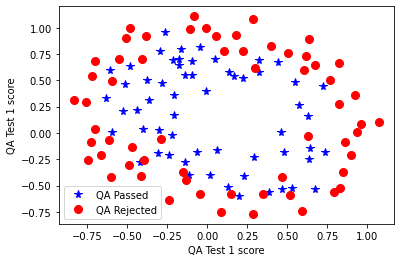

In [5]:
microchip_quality.plot_data(X,y)
plt.show()

It seems features mapping is necessary since the QA status is not easily distinguished by a linear line.

The features mapping is now then performed

In [6]:
X = microchip_quality.features_mapping(X[:,0], X[:,1])

In [7]:
theta = microchip_quality.scipy_optimize(X, 400, 1)

The `scipy_optimize` return the `theta` with the lowest cost. Let's evaluate the model accuracy,

In [8]:
p, qa_status = microchip_quality.predict(X, theta)

print('Model Accuracy: {:.2f} %'.format(np.mean(qa_status == y) * 100))

Model Accuracy: 83.05 %


The model has the accuracy of **83.05%** to classify the `qa_status`. Moreover, let's plot the `decision boundary` to have intuition how good the model is,

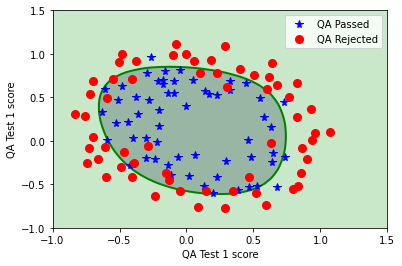

In [9]:
microchip_quality.plot_decision_boundary(theta, X, y)

The decision boundary seems able to distinguish the admission status. 

<a id="section4"></a>
## 4:  Role of Hyperparameter $\lambda$ in Regularization
In this section, we will investigate  the role of hyperparameter $\lambda$ in regularization. Let's compare the decision boundary with $\lambda$ = 0 (no regularization), $\lambda$ = 1, $\lambda$ = 10.

Starting with $\lambda$ = 0 (no regularization),

Text(0.5, 1.0, 'lambda = 0')

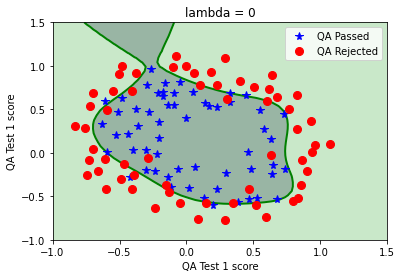

In [10]:
theta_lambda_0 = microchip_quality.scipy_optimize(X, 400, 0)

microchip_quality.plot_decision_boundary(theta_lambda_0, X, y)
plt.title('lambda = 0')

With a small $\lambda$, the classifier gets almost every training example correct but draws a very complicated boundary, thus overfitting the data. If the overfitting occurs, the model is likely not to generalize well to the new data.

See the following figures for the decision boundaries you should get for different values of $\lambda$ = 1,

Text(0.5, 1.0, 'lambda = 1')

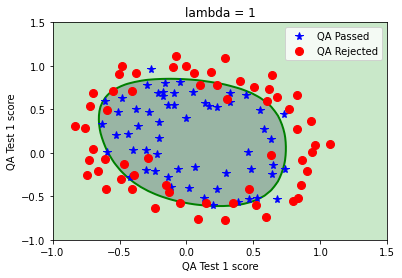

In [11]:
theta_lambda_1 = microchip_quality.scipy_optimize(X, 400, 1)

microchip_quality.plot_decision_boundary(theta_lambda_1, X, y)
plt.title('lambda = 1')

Last but not least, if the $\lambda$ = 100 (high),

Text(0.5, 1.0, 'lambda = 100')

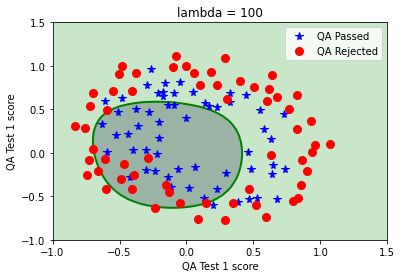

In [12]:
theta_lambda_100 = microchip_quality.scipy_optimize(X, 400, 100)

microchip_quality.plot_decision_boundary(theta_lambda_100, X, y)
plt.title('lambda = 100')

As we vary $\lambda$, notice the changes in the decision boundary. With a proper $\lambda$, we find that the classifier gets almost every training example correct. Moreover, it is likely the model generalize well to the new data. On the other hand, the model will introduce too much bias if the $\lambda$ is too high.

To conclude, the regularization is important to ensure the model will generalize well to the new data. In addition, the $\lambda$ hyperparameter should be carefully chosen to ensure it is not too small (variance/overfitting problem) or too high (biased/underfitting problem).

<a id="section5"></a>
## 5:  Conclusion
In this project, we have successfully developed a Machine Learning algorithm using Regularized Logistic Regression and Scipy Optimization. The role of hyperparameter $\lambda$ has been investigated as well. The regularization is proven to help the model to generalize well to the new data. Moreover, the algorithm is proven able to produce a good hypothesis $h_{\theta}(x)$ given a proper $\lambda$. 